fonte: https://www.geeksforgeeks.org/time-series-forecasting-with-support-vector-regression/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


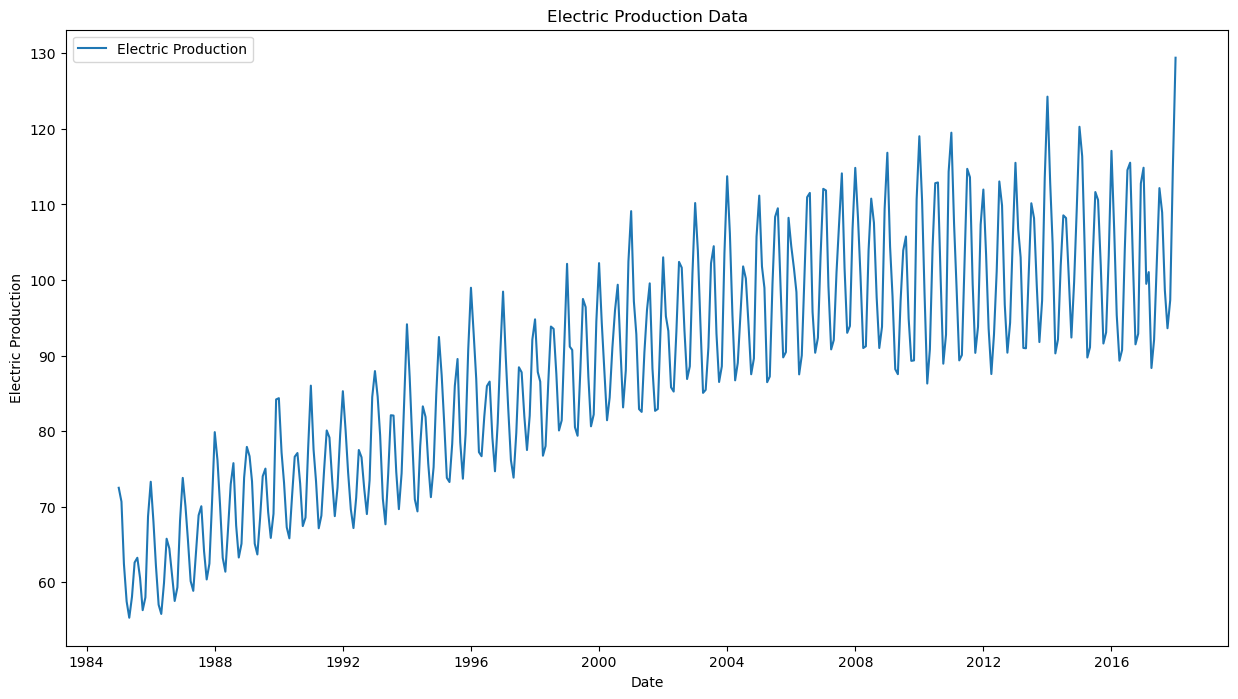

In [2]:
# Load the dataset
df = pd.read_csv('Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['IPG2211A2N'], label='Electric Production')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Data')
plt.legend()
plt.show()


In [3]:
# Create training and testing datasets
train_start_dt = '1985-01-01'
test_start_dt = '2005-01-01'
train = df.loc[train_start_dt:test_start_dt]
test = df.loc[test_start_dt:]
train.head()


,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [5]:
# Prepare the data for training
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 5
X_train, y_train = create_dataset(train_scaled, train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_scaled, test_scaled, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(236, 5, 1) (236, 1)
(152, 5, 1) (152, 1)


In [6]:
# SVR model
model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)

# Fit the model
model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())


SVR(C=10, epsilon=0.05, gamma=0.5)

In [7]:
# Make predictions
train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Inverse scaling
train_pred_inv = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


In [8]:
# Evaluate the model
mse_train = mean_squared_error(y_train_inv, train_pred_inv)
mse_test = mean_squared_error(y_test_inv, test_pred_inv)
print("Mean Squared Error on Training Data:", mse_train)
print("Mean Squared Error on Testing Data:", mse_test)


Mean Squared Error on Training Data: 7.289992919226606
Mean Squared Error on Testing Data: 21.34532107347821


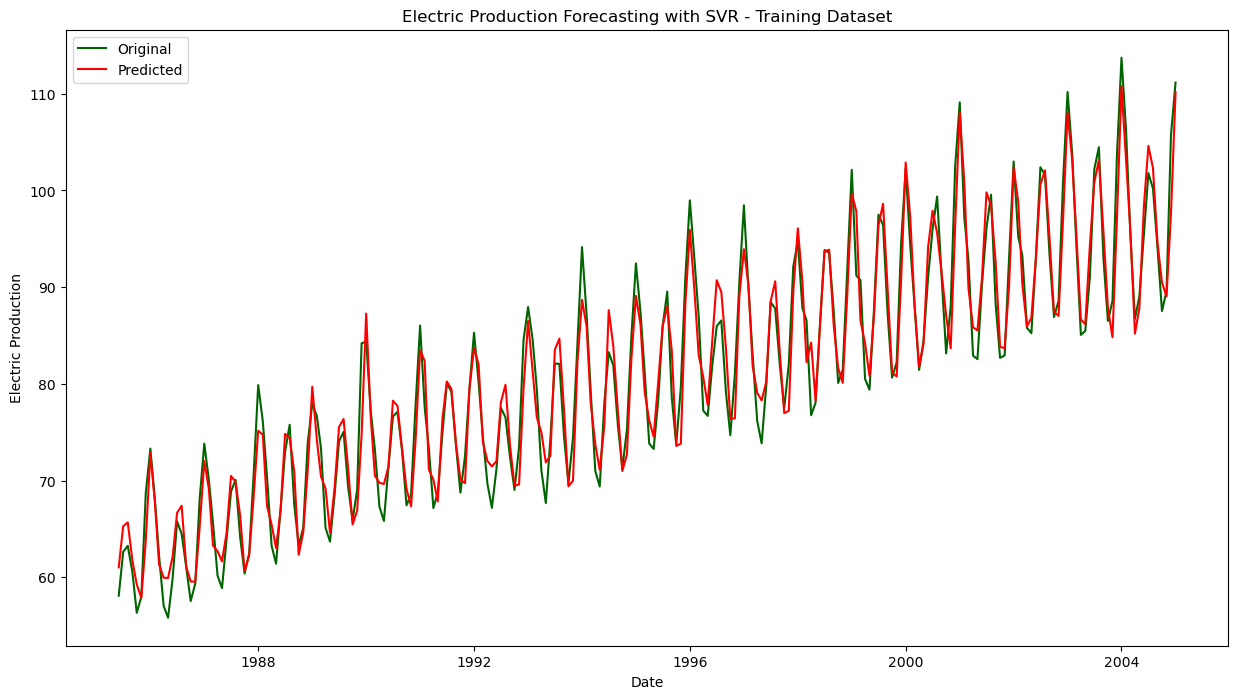

In [9]:
# Plotting the results for train dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], y_train_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], train_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Forecasting with SVR - Training Dataset')
plt.legend()
plt.show()


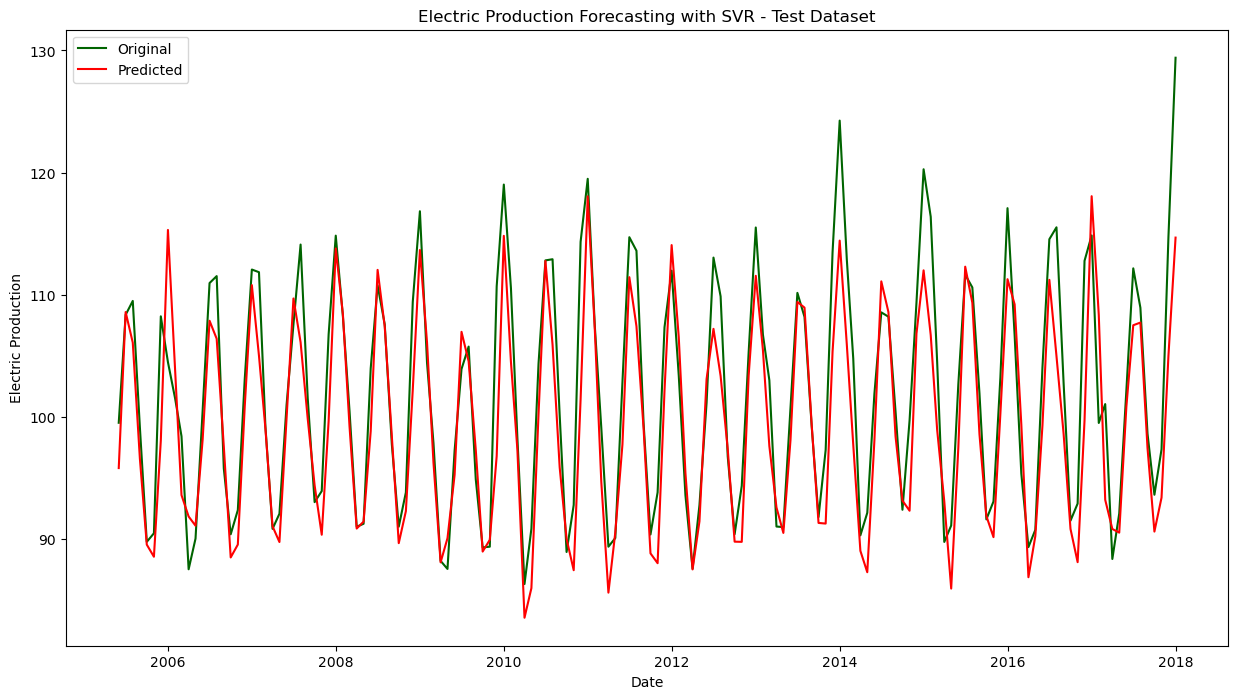

In [10]:
# Plotting the results for test dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS-1:], y_test_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS-1:], test_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Forecasting with SVR - Test Dataset')
plt.legend()
plt.show()


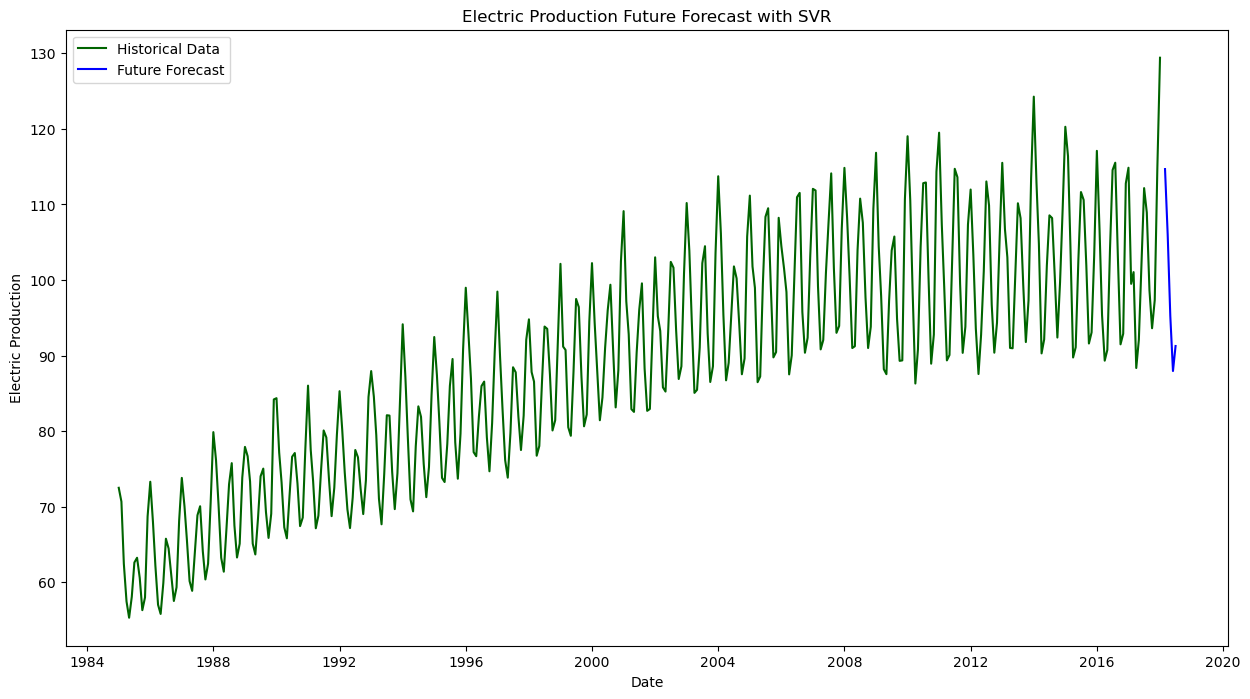

In [11]:
# Number of future time steps to forecast
future_steps = 5  # Adjust this as needed

# Last `TIME_STEPS` values from the test set to start forecasting
last_sequence = X_test[-1]

# Forecast future values
future_forecast = []
for _ in range(future_steps):
    # Predict next value based on the last sequence
    next_pred = model.predict(last_sequence.reshape(1, -1))
    future_forecast.append(next_pred[0])
    # Update the last sequence by removing the first element and adding the predicted value
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

# Inverse scaling for future forecast
future_forecast_inv = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Generate future timestamps
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='M')[1:]

# Plotting the future forecast
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['IPG2211A2N'], label='Historical Data', color='darkgreen')
plt.plot(future_dates, future_forecast_inv, label='Future Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Future Forecast with SVR')
plt.legend()
plt.show()
